# COGS 108 Final Project

## Group Members: 
- A13382470

### Introduction and Background:



Which components of a kickstarter are most important for a fundraiser to reach its goal? How do factors such as date started, duration, money goal, and category of a kickstarter , comparatively, influence fundraiser success? Answering these questions can guide those who are looking to create their own kickstarter and start a successful business. There have been previous projects in this area studying what separates successful kickstarters from failed ones. We take a different approach and analyze how these factors rank against each other.  

Our initial hypothesis is that kickstarter category will be the most important factor in kickstarter success, due to some categories being inherently more popular and appealing than others. Categories such as “Design and Tech” category will likely be more successful due to the popularity surrounding technology-driven products.


### Data Description:


Dataset Name: Kickstarter Datasets (Web Robots)

Link to the dataset: https://webrobots.io/kickstarter-datasets/

Number of observations: 207k

The dataset is a large (200k+) collection of data about different Kickstarters, including whether they succeed in reaching their goal. Other information pertaining to the kickstarter range from the name and category of the kickstarter to how much it is asking for or how long the fundraising period was.

The information includes: ID, internal kickstarter id, name, name of project, category, main_category, category of campaign, currency used to support, deadline for crowdfunding, fundraising goal, date launched, amount pledged by "crowd", current condition the project is in.


### Starting out: imports

In [5]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import operator

from datetime import datetime, timedelta

### Data Cleaning and Pre-processing

Here we load the JSON file and select the columns that we want from the web-scraper's data. We also have to apply a function to parse the category name as it is separated by a forward slash 

In [6]:
with open('Kickstarter_2018-12-13T03_20_05_701Z.json') as f:
    
    data = []
    
    # Iterate through each line in file which is a JSON object
    for line in f:
        
        # Load object
        obj = json.loads(line)
 
        # Choose columns
        item = []
        item.append(obj['data']['id'])
        item.append(obj['data']['name'])
        item.append(obj['data']['blurb'])
        item.append(obj['data']['goal'])
        item.append(obj['data']['pledged'])
        item.append(obj['data']['state'])
        item.append(obj['data']['country'])
        item.append(obj['data']['deadline'])
        item.append(obj['data']['created_at'])
        item.append(obj['data']['launched_at'])
        item.append(obj['data']['backers_count'])
        item.append(obj['data']['usd_pledged'])
        item.append(obj['data']['category']['slug'])
        item.append(obj['data']['category']['name'])
        data.append(item)
        
# Fix columns list if adding/removing columns
columns = ['id', 'name', 'blurb', 'goal', 'pledged', 'state', 'country', 'deadline', 'created_at', 'launched_at', 'backers_count', 'usd_pledged', 'category', 'subcategory']
df = pd.DataFrame(data, columns=columns)

def getCategory(name):
    return name.split('/')[0]

# Fix category
df['category'] = df['category'].apply(getCategory)
df.head()

,id,name,blurb,goal,pledged,state,country,deadline,created_at,launched_at,backers_count,usd_pledged,category,subcategory
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,25000.0,27455.55,successful,US,1353256229,1339525842,1350660629,170,27455.55,film & video,Documentary
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,500.0,535.00,successful,US,1355949544,1351941026,1353357544,10,535.0,publishing,Children's Books
2,1745190062,DC Radio,We are college students that get drunk and the...,3500.0,0.00,failed,CA,1418916011,1415917256,1416324011,0,0.0,journalism,Audio
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",20000.0,0.00,failed,US,1449345000,1446664703,1446672167,0,0.0,music,World Music
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,5000.0,6705.00,successful,US,1287200340,1284003536,1284042614,62,6705.0,film & video,Documentary


Next, we notice that the deadline, created_at, and launched_at values look odd. Turns out they are in unix time, we we will transform them to be more readable.

In [7]:
deadline_str = []
duration_str = []
launch_date = []
deadline_int = []

for i, row in df.iterrows():

    unix_ts = int(row['deadline'])
    dt = (datetime.fromtimestamp(unix_ts) - timedelta(hours=2)).strftime('%Y-%m-%d %H:%M:%S')
    deadline_str.append(dt)
    
    launch_date_ts = int(row['launched_at'])
    launch_dt = (datetime.fromtimestamp(launch_date_ts) - timedelta(hours=2)).strftime('%Y-%m-%d %H:%M:%S')
    launch_date.append(launch_dt)
    
    duration_unix_ts = unix_ts - launch_date_ts
    duration_days = (duration_unix_ts / (60*60*24))
    duration_str.append(duration_days)
    
df['launched_at_str'] = launch_date
df['deadline_str'] = deadline_str
df['duration_days'] = duration_str

for i, row in df.iterrows():
    
    dt = row['deadline_str']
    dt2 = dt.split(' ')[0].split('-')[1]+dt.split(' ')[0].split('-')[2]+dt.split(' ')[0].split('-')[0]
    deadline_int.append(dt2)

df['deadline_int'] = deadline_int

# Drop columns we don't need anymore
df.drop(labels=['deadline', 'created_at', 'launched_at'], axis=1, inplace=True)
    
# Check df
df.head()

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,25000.0,27455.55,successful,US,170,27455.55,film & video,Documentary,2012-10-19 06:30:29,2012-11-18 06:30:29,30.041667,11182012
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,500.0,535.00,successful,US,10,535.0,publishing,Children's Books,2012-11-19 10:39:04,2012-12-19 10:39:04,30.000000,12192012
2,1745190062,DC Radio,We are college students that get drunk and the...,3500.0,0.00,failed,CA,0,0.0,journalism,Audio,2014-11-18 05:20:11,2014-12-18 05:20:11,30.000000,12182014
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",20000.0,0.00,failed,US,0,0.0,music,World Music,2015-11-04 11:22:47,2015-12-05 09:50:00,30.935567,12052015
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,5000.0,6705.00,successful,US,62,6705.0,film & video,Documentary,2010-09-09 05:30:14,2010-10-15 18:39:00,36.547755,10152010


Check for any null values in our DataFrame

In [8]:
df.loc[df.isnull().any(axis=1)==True,:]

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int


As we can see above there are no rows with null values, so we don't have to worry about dealing with null values.

### Data Visualization

#### Impact of Categories and Subcategories

Let's start by looking at how different categories and subcategories rank against each other:

In [9]:
# Code for successful kickstarters in 'category'
item = df['category'].unique()
out = {}
counts = df['category'].value_counts().tolist()
for val in item:
    temp = df[(df['category']== val) & (df['state']=='successful')]['id'].size
    out[val] = temp
    
# Code for successful kickstarters in 'subcategory'
item2 = df['subcategory'].unique()
out2 = {}
counts1 = df['subcategory'].value_counts().tolist()
for val in item2:
    temp2 = df[(df['subcategory']== val) & (df['state']=='successful')]['id'].size
    out2[val] = temp2
    
# Code to get success rate for 'category'
dict1 = df['category'].value_counts().to_dict() # total vals
dict2 = out # successful (out)
dict3 = {} # success rate
for cat in item:
    total = dict1[cat]
    success = dict2[cat]
    dict3[cat] = success/total
testList = list(dict3.values())
testList2 = np.sort(testList)
testList3 = testList2[::-1]
sorted_x = sorted(dict3.items(), key=operator.itemgetter(1), reverse=True)

# Code to get success rate for 'subcategory'
dict4 = df['subcategory'].value_counts().to_dict() # total vals
dict5 = out2 # successful (out)
dict6 = {} # success rate
for cat in item2:
    total2 = dict4[cat]
    success2 = dict5[cat]
    dict6[cat] = success2/total2
testList4 = list(dict6.values())
testList5 = np.sort(testList4)
testList6 = testList5[::-1]
sorted_x2 = sorted(dict6.items(), key=operator.itemgetter(1), reverse=True)

In [10]:
print("Here is the success rate for the categories:")
print(sorted_x)
print("Here is the success rate for the categories:")
print(sorted_x2)

Here is the success rate for the categories:
[('dance', 0.8158745956705649), ('comics', 0.7839293901879871), ('theater', 0.7053268407850081), ('publishing', 0.6799820242672392), ('music', 0.6541375505700625), ('games', 0.6097665759702133), ('design', 0.6040672574414906), ('fashion', 0.5698455339153794), ('film & video', 0.5662278149549025), ('art', 0.559406667645763), ('photography', 0.5006256256256256), ('crafts', 0.48088048539579514), ('technology', 0.37732704851687854), ('food', 0.34308841843088417), ('journalism', 0.3061792863359443)]
Here is the success rate for the categories:
[('Theater', 0.9974293059125964), ('Dance', 0.9961513790891597), ('Photography', 0.992953611274222), ('Comics', 0.9918533604887984), ('Indie Rock', 0.989492119089317), ('Country & Folk', 0.9804143126177024), ('Fashion', 0.9796495195025439), ('Rock', 0.9792592592592593), ('Food', 0.9752973467520586), ('Shorts', 0.9737991266375546), ('Fiction', 0.968986905582357), ('Crafts', 0.966412213740458), ('Nonfiction',

#### Impact of Project Description Words

Next, we will examine how using certain words to describe a Kickstarter project may have an effect on the success. We begin by separating successful and failed projects. Then, we want to create a dataframe with each word and the number of times it appears.

In [109]:
# Create dataframes for kickstarters that are successful and fail
df_successful = df.loc[df['state']=='successful',:]
df_fail = df.loc[df['state']=='failed',:]

In [110]:
# Create a dictionary of words with their counts
success_words = {}
fail_words = {}

for description in df_successful['blurb']:
    for word in description.split(' '):
        word = word.lower()
        word = word.strip()
        word = word.replace('.', '')
        word = word.replace("\"", '')
        word = word.replace(',', '')
        word = word.replace(';', '')
        word = word.replace('!', '')
        word = word.replace('?', '')
        word = word.replace('\n', '')
        
        if len(word) == 0:
            continue
        elif word not in success_words:
            success_words[word] = 1
        else:
            success_words[word] += 1
            
for description in df_fail['blurb']:
    for word in description.split(' '):
        word = word.lower()
        word = word.strip()
        word = word.replace('.', '')
        word = word.replace("\"", '')
        word = word.replace(',', '')
        word = word.replace(';', '')
        word = word.replace('!', '')
        word = word.replace('?', '')
        word = word.replace('\n', '')
        
        if len(word) == 0:
            continue
        elif word not in fail_words:
            fail_words[word] = 1
        else:
            fail_words[word] += 1

df_success_words = pd.DataFrame.from_dict(success_words, orient='index', columns=['count'])
df_fail_words = pd.DataFrame.from_dict(fail_words, orient='index', columns=['count'])

We don't care about stop words, because they are bound to appear in any description. We want to focus on more unique words so these stop words (based on https://www.textfixer.com/tutorials/common-english-words.txt) will be dropped.

In [111]:
# Drop stop words
common = ['a','able','about','across','after','all','almost','also','am','among','an','and','any','are',
          'as','at','be','because','been','but','by','can','cannot','could','dear','did','do','does',
          'either','else','ever','every','for','from','get','got','had','has','have','he','her','hers',
          'him','his','how','however','i','if','in','into','is','it','its','just','least','let','like',
          'likely','may','me','might','most','must','my','neither','no','nor','not','of','off','often',
          'on','only','or','other','our','own','rather','said','say','says','she','should','since','so',
          'some','than','that','the','their','them','then','there','these','they','this','to','too',
          'twas','us','wants','was','we','were','what','when','where','which','while','who','whom','why',
          'will','with','would','yet','you','your', '-', '&', "i'm", "it's"]

df_success_words.drop(common, inplace=True)
df_fail_words.drop(common, inplace=True)

We have removed the stop words but there are also words that appear very few times. There no point in looking at words with such low counts so we will filter words that fall below a certain threshold. Here, we are aiming to narrow down to about 25 words, so that we are not overwhelmed with words

In [112]:
# Get rid of words with low frequency
df_success_words = df_success_words.loc[df_success_words['count']>3000,:]
df_success_words.sort_values(by=['count'], ascending=False, inplace=True)

df_fail_words = df_fail_words.loc[df_fail_words['count']>2000,:]
df_fail_words.sort_values(by=['count'], ascending=False, inplace=True)

# Fix indexing and make column for word
df_success_words.reset_index(inplace=True)
df_success_words.columns = ['word', 'count']

df_fail_words.reset_index(inplace=True)
df_fail_words.columns = ['word', 'count']

In [113]:
df_success_words.head(n=10)

,word,count
0,help,14215
1,new,12969
2,book,7550
3,first,6902
4,album,6635
5,art,6405
6,music,5826
7,world,5647
8,make,5205
9,film,5117


In [114]:
df_fail_words.head(n=10)

,word,count
0,help,7201
1,new,5908
2,music,4136
3,make,4060
4,want,3886
5,world,3882
6,art,3695
7,create,3338
8,people,3205
9,project,3184


Now that we have the words and their counts, we can plot to see how common certain words in successful projects are

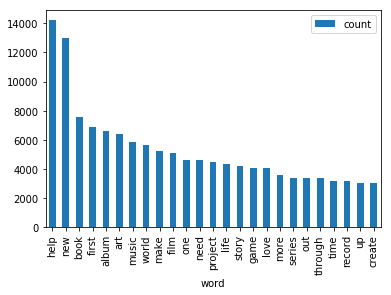

In [115]:
df_success_words.plot(x='word', kind='bar')

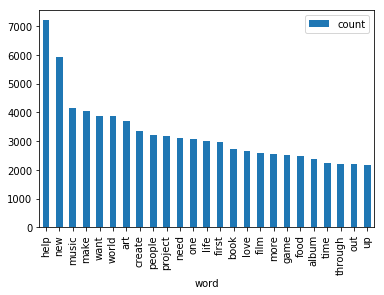

In [116]:
df_fail_words.plot(x='word', kind='bar')

#### Impact of Start Date and Duration

#### Impact of Goal Amount

### Data Analysis and Results##

#### Impact of Categories and Subcategories

#### Impact of Project Description Words

In the data visualization, we saw that the top 5 words to used in successful projects were "help", "new", "book", "first", and "album". However, it seemed a bit suspicious that using the word "help" had such an impact on the success of a kickstarter. Therefore, we examined the unsuccessful projects and "help" was also the most used word. The same applied to the word "new". This brings us towards the idea that "help" and "new" are words common to any Kickstarter project, especially with their extremely high counts, and their use does not have a direct relation with the success of a project. If we look at the bar plots we had generated before, the word count increase quite linearly, but once we get to "help" and "new", the values jump up eratically. We shall drop these two words from our dataframes.

In [124]:
df_success_words = df_success_words.loc[ ( (df_success_words['word'] != 'help') & (df_success_words['word'] != 'new') ),: ]
df_success_words.reset_index(drop=True, inplace=True)

df_fail_words = df_fail_words.loc[ ( (df_fail_words['word'] != 'help') & (df_fail_words['word'] != 'new') ),: ]
df_fail_words.reset_index(drop=True, inplace=True)

print("Success words: ")
print(list(df_success_words['word']))
print("\nFail words: ")
print(list(df_fail_words['word']))

Success words: 
['book', 'first', 'album', 'art', 'music', 'world', 'make', 'film', 'one', 'need', 'project', 'life', 'story', 'game', 'love', 'more', 'series', 'out', 'through', 'time', 'record', 'up', 'create']

Fail words: 
['music', 'make', 'want', 'world', 'art', 'create', 'people', 'project', 'need', 'one', 'life', 'first', 'book', 'love', 'film', 'more', 'game', 'food', 'album', 'time', 'through', 'out', 'up']


Even without "help" and "new", we still find a bunch of words in the succesful projects that are also top words in unsuccessful projects. This leads us to believe that perhaps these words don't have an effect on the success on a Kickstarter. It makes sense that these words are common in both successful and failed projects because they relate to the different categories and subcategories. For example, many kickstarter projects will be about books, music, art, dance, etc. A Kickstarter project in a particular category is probably going to mention words pertaining to its category and doing so probably will not affect the success or failure since it is bound to happen in virtually all project descriptions. Just to make sure, we will look for top words that only appear in successful and see if they would be significant or not towards a project's success.

In [128]:
def find_uniques(list1, list2):
    result = []
    for word in list1:
        if word not in list2:
            result.append(word) 
    return result

uniques = find_uniques(list(df_success_words['word']), list(df_fail_words['word']))
print(uniques)

['story', 'series', 'record']


We find that the only uniquely successful words are 'story', 'series', and 'record'. Based on the dataset, these words have some correlation to success but it is not the causation of success. One connection is that these three words are all related to some form of art such as books, comics, and music, and the arts tend to be the more popular categories. Therefore, one cannot use certain words to directly make their Kickstarter project succeed. Instead, it seems that the category of the project drives users to use certain words to describe their project and certain categories are more successful than others.

#### Impact of Start Date and Duration

#### Impact of Goal Amount

### Privacy and Ethics Considerations

For our research question, we chose to look at what makes a kickstarter project successful.  This data was collected on a website whose owners got the data by webscrapping kickstarter.  The only potential privacy issue would be that the users of kickstarter did not give us direct consent to analyze their data.  However, because kickstarter is a public forum, in order to use the site, users do have to acknowledge that the data will note be private. 

Additionally, we aren’t using the data to create revenue and instead using it for an academic purpose. Thus, it’s unlikely there will be issues related to privacy. Furthermore, our data does not violate the safe harbor laws as no names, addresses or other identifying information is included within the dataset.


### Conclusions and Discussion:



Work in progress.